### ANN weights optimization with metaheuristic algorithms

Here we want to train an ANN to generate 3 integer numbers $(a,b,c)$, such as:

- $a \geq 0$
- $b \leq 0$
- $c = 0$

In [88]:
import numpy as np
import tensorflow as tf
import time
import random
import matplotlib.pyplot as plt
import cProfile as profile

from evomip.Constraint import Constraint
from evomip.Parameter import *
from evomip.SearchSpace import SearchSpace
from evomip.Population import Population
from evomip.Config import Config
from evomip.WOA import WOA

In [89]:
class NetStructure:
    def __init__(self, input_dim, output_dim):
        self.input_dim  = input_dim
        self.n_hidden   = 0
        self.hidden_dim = []
        self.output_dim = output_dim
        self.activation = []

    def add_hidden(self, hidden_dim, activation = 'linear'):
        self.n_hidden += 1
        self.hidden_dim.append(hidden_dim)
        self.activation.append(activation)

    def get_input_dim(self):
        return self.input_dim

    def get_output_dim(self):
        return self.output_dim

    def get_num_hidden(self):
        return self.n_hidden

    def get_hidden_dim(self, index):
        return self.hidden_dim[index]

    def get_activation(self, index):
        return self.activation[index]

    def print(self):
        print("----------------------")
        print("    Input dim:", self.input_dim)
        for i in range(self.n_hidden):
            print(" Hidden", i+1, "dim:", self.hidden_dim[i], "- activation:", self.activation[i])
        print("   Output dim:", self.output_dim)
        print("----------------------")

In [90]:
class Model:
    def __init__(self, net_structure):
        self.net_structure  = net_structure
        
        # range on latent points
        self.latent_points_range = [-200., 200.]

        # definisco il modello sulla base della struttura che gli ho passato
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(net_structure.get_hidden_dim(0), activation=net_structure.get_activation(0), input_dim=net_structure.get_input_dim()))
        for i in range(1, net_structure.get_num_hidden()):
            self.model.add(tf.keras.layers.Dense(net_structure.get_hidden_dim(i), activation=net_structure.get_activation(i)))
        self.model.add(tf.keras.layers.Dense(net_structure.get_output_dim()))
        
        # random generatin of biases
        nl = len(self.model.layers)
        self.bias = []
        for p in range(0, nl):
            nw = self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1]
            self.bias.append(np.random.uniform(0, 100, self.model.layers[p].count_params() - nw))
            
    def set_latent_points_range(self, minv, maxv):
        self.latent_points_range = [minv, maxv]

    def set_num_iterations(self, num_iterations):
        self.num_iterations = num_iterations

    def set_population_size(self, population_size):
        self.population_size = population_size
        
    def generate_latent_points(self, sample_size) -> np.array:
        self.latent_points = np.random.uniform(self.latent_points_range[0], self.latent_points_range[1], (sample_size, self.net_structure.get_input_dim()))

    def update_model_with_parameters(self, opt_par):
        nl = len(self.model.layers)
        wbindex = 0
        for p in range(0, nl):
            W = opt_par[wbindex:(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1])]
            self.model.layers[p].set_weights([W.reshape(self.model.layers[p].input.shape[1], self.model.layers[p].output.shape[1]), self.bias[p]])
            wbindex += len(W)

    def optimize(self):
        # configuration   
        config = Config(nmax_iter=self.num_iterations, seed=11, nmax_iter_same_cost=0, silent=False)

        # parameters and search space
        pars = []
        for p in range(0, len(model.model.layers)):
            nw = self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1]
            pars = pars + createListParameters("w" + str(p), nw, -1., 1.)
        
        self.sspace = SearchSpace(pars)
        
        # population
        population = Population(self.population_size, self.objective_function, self.sspace, config)
        self.algo = WOA(population)
        self.algo.minimize()

    def objective_function(self, opt_par):
        self.update_model_with_parameters(opt_par)
        sum = 0.
        y_pred = self.model.predict(self.latent_points, verbose = 0)
        for i in range(0, len(y_pred)):
            a = int(y_pred[i,0])
            b = int(y_pred[i,1])
            c = int(y_pred[i,2])
            if (a < 0):
                sum += abs(a)
            if (b > 0):
                sum += b
            sum += abs(c)
        return sum

    def generate(self):
        # randomly generate the latent points
        self.generate_latent_points(1)
        y_pred = self.model.predict(self.latent_points, verbose = 0)
        return [int(y_pred[0][0]), int(y_pred[0][1]), int(y_pred[0][2])]

In [91]:
net = NetStructure(input_dim=1, output_dim=3)
net.add_hidden(hidden_dim=10)

model = Model(net)
model.generate_latent_points(1000)
model.set_num_iterations(200)
model.set_population_size(100)
model.optimize()  

Generating the initial population...



100%|██████████| 200/200 [08:12<00:00,  2.46s/it]


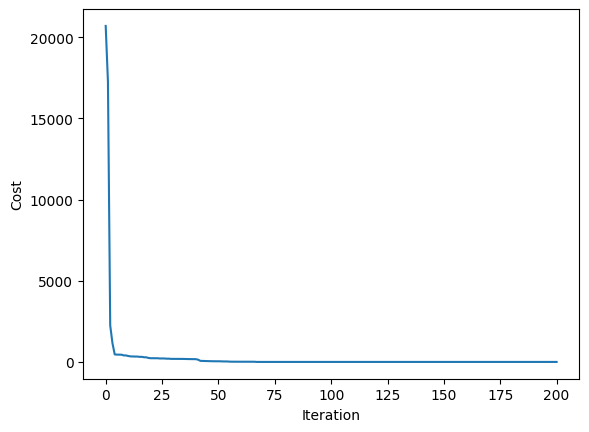

Best cost: 0.0


In [102]:
ys = model.algo.costHistory
xs = [x for x in range(len(ys))]
plt.plot(xs, ys)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

print("Best cost:", ys[len(ys)-1])

Let's check by hand some new data...

In [100]:
def is_good_generation(gen) -> bool:
    a = gen[0]
    b = gen[1]
    c = gen[2]
    if (a < 0 or b > 0 or c != 0):
        return False
    return True
     

for i in range(10):               
    x = model.generate()                
    print(x, is_good_generation(x))

[53, -70, 0] True
[85, -43, 0] True
[33, -87, 0] True
[85, -43, 0] True
[55, -69, 0] True
[79, -48, 0] True
[61, -63, 0] True
[30, -90, 0] True
[111, -21, 0] True
[52, -72, 0] True


They are all fine. Now let's generate a larger test sample and compute the accuracy.

In [99]:
test_size = 1000
xs = [model.generate() for i in range(test_size)]
right_x = 0
for x in xs:
    if (is_good_generation(x)):
        right_x += 1
        
print("Accuracy: ", 100.*right_x/test_size, "% (", right_x, "/", test_size, ")", sep="")

Accuracy: 100.0% (1000/1000)
